# Calculating Determinant

This ipython notebook is written for calculating the determinant of the state-dependent Jacobian matrix.

A linear inverse model is given by
$$
M(t_0 + \tau) = G_{\tau} M(t_0) + \epsilon
$$
where $M$ is the state vector, $t_0$ is the initial time, $\tau$ is the forecast lead time, $G_{\tau}$ is the Jacobian matrix, $\epsilon$ is the white noise forcing.

Liouville equation is given by
$$
\frac{d \rho}{dt} = \frac{\partial \rho}{\partial t} + \vec{v} \cdot \nabla \rho = -\rho \nabla \cdot \vec{v}
$$
where $\rho$ is the ensemble density, $\vec{v}$ is the Liouville flow. The Lagragian change of ensemble density $d\rho / dt$ is determined by the convergence/divergence of the Liouville flow $-\rho \nabla \cdot \vec{v}$. Liouville 1838 demonstrates that the convergence/divergence of the Liouville flow is equivalent to the determinant of the Jacobian matrix $G_{\tau}$.

## Packages

In [1]:
import numpy as np
from scipy.linalg import expm
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

In [2]:
from util.plotter import plot_phase

## Read Data

In [3]:
M     = np.load("M.npy")
dM_dt = np.roll(M, -1, axis = 1) - M # using Euler method to ensure the mathematical consistency
G     = expm(np.dot(dM_dt, M.T).dot(np.linalg.inv(np.dot(M, M.T)))) # Jacobian matrix
cov   = np.load("noise.npy") # covariance matrix of the noise

## Calculating Determinant

The Lagrangian change of ensemble density is determined by the local convergence/divergence of the Liouville flow. For a LIM with homogeneous Jacobian matrix and external forcing throughout the phase space, the Liouville flow is non-divergent. However, we consider state-dependent forcing in our model, so the convergence/divergence of Liouville flow is state-dependent as well. The concept of calculating the state-dependent "effective" Jacobian matrices and their determinant is somewhat similar to that of calculating the forcing:

1. Choose a position in the phase space.
2. Initialize a group of particles as the initial condition.
3. Predict those particles' movement with global Jacobian matrix and state-dependent white noise forcing.
4. Calculate the "effective" Jacobian matrix and the associated determinant.

In [4]:
# The noise is added to the system at each initial position
def noise_at_each_timestep(cov, size = 1):
    noise = np.random.multivariate_normal([0, 0], cov, size = size)
    return noise.T

In [5]:
xx = np.arange(-4, 4+1e-4, 0.02)
yy = np.arange(-4, 4+1e-4, 0.02)
X, Y = np.meshgrid(xx, yy)

In [8]:
G_list = np.zeros(X.shape + (2, 2,)) # state-dependent Jacobian matrix
det    = np.zeros(X.shape) # determinant of the state-dependent Jacobian matrix

for j, y in enumerate(yy):
    for i, x in enumerate(xx):
        Xin   = np.repeat(np.array([[x], [y]]), 100, axis = 1) + np.random.normal(size = (2, 100)) # initialize 100 particles
        noise = noise_at_each_timestep(cov[j, i], size = 100)
        Xout  = G.dot(Xin) + noise
        G_list[j, i] = np.dot(Xout, Xout.T).dot(np.linalg.inv(np.dot(Xin, Xout.T)))
        det[j, i]    = np.linalg.det(G_list[j, i])
        
np.save("det.npy", det)

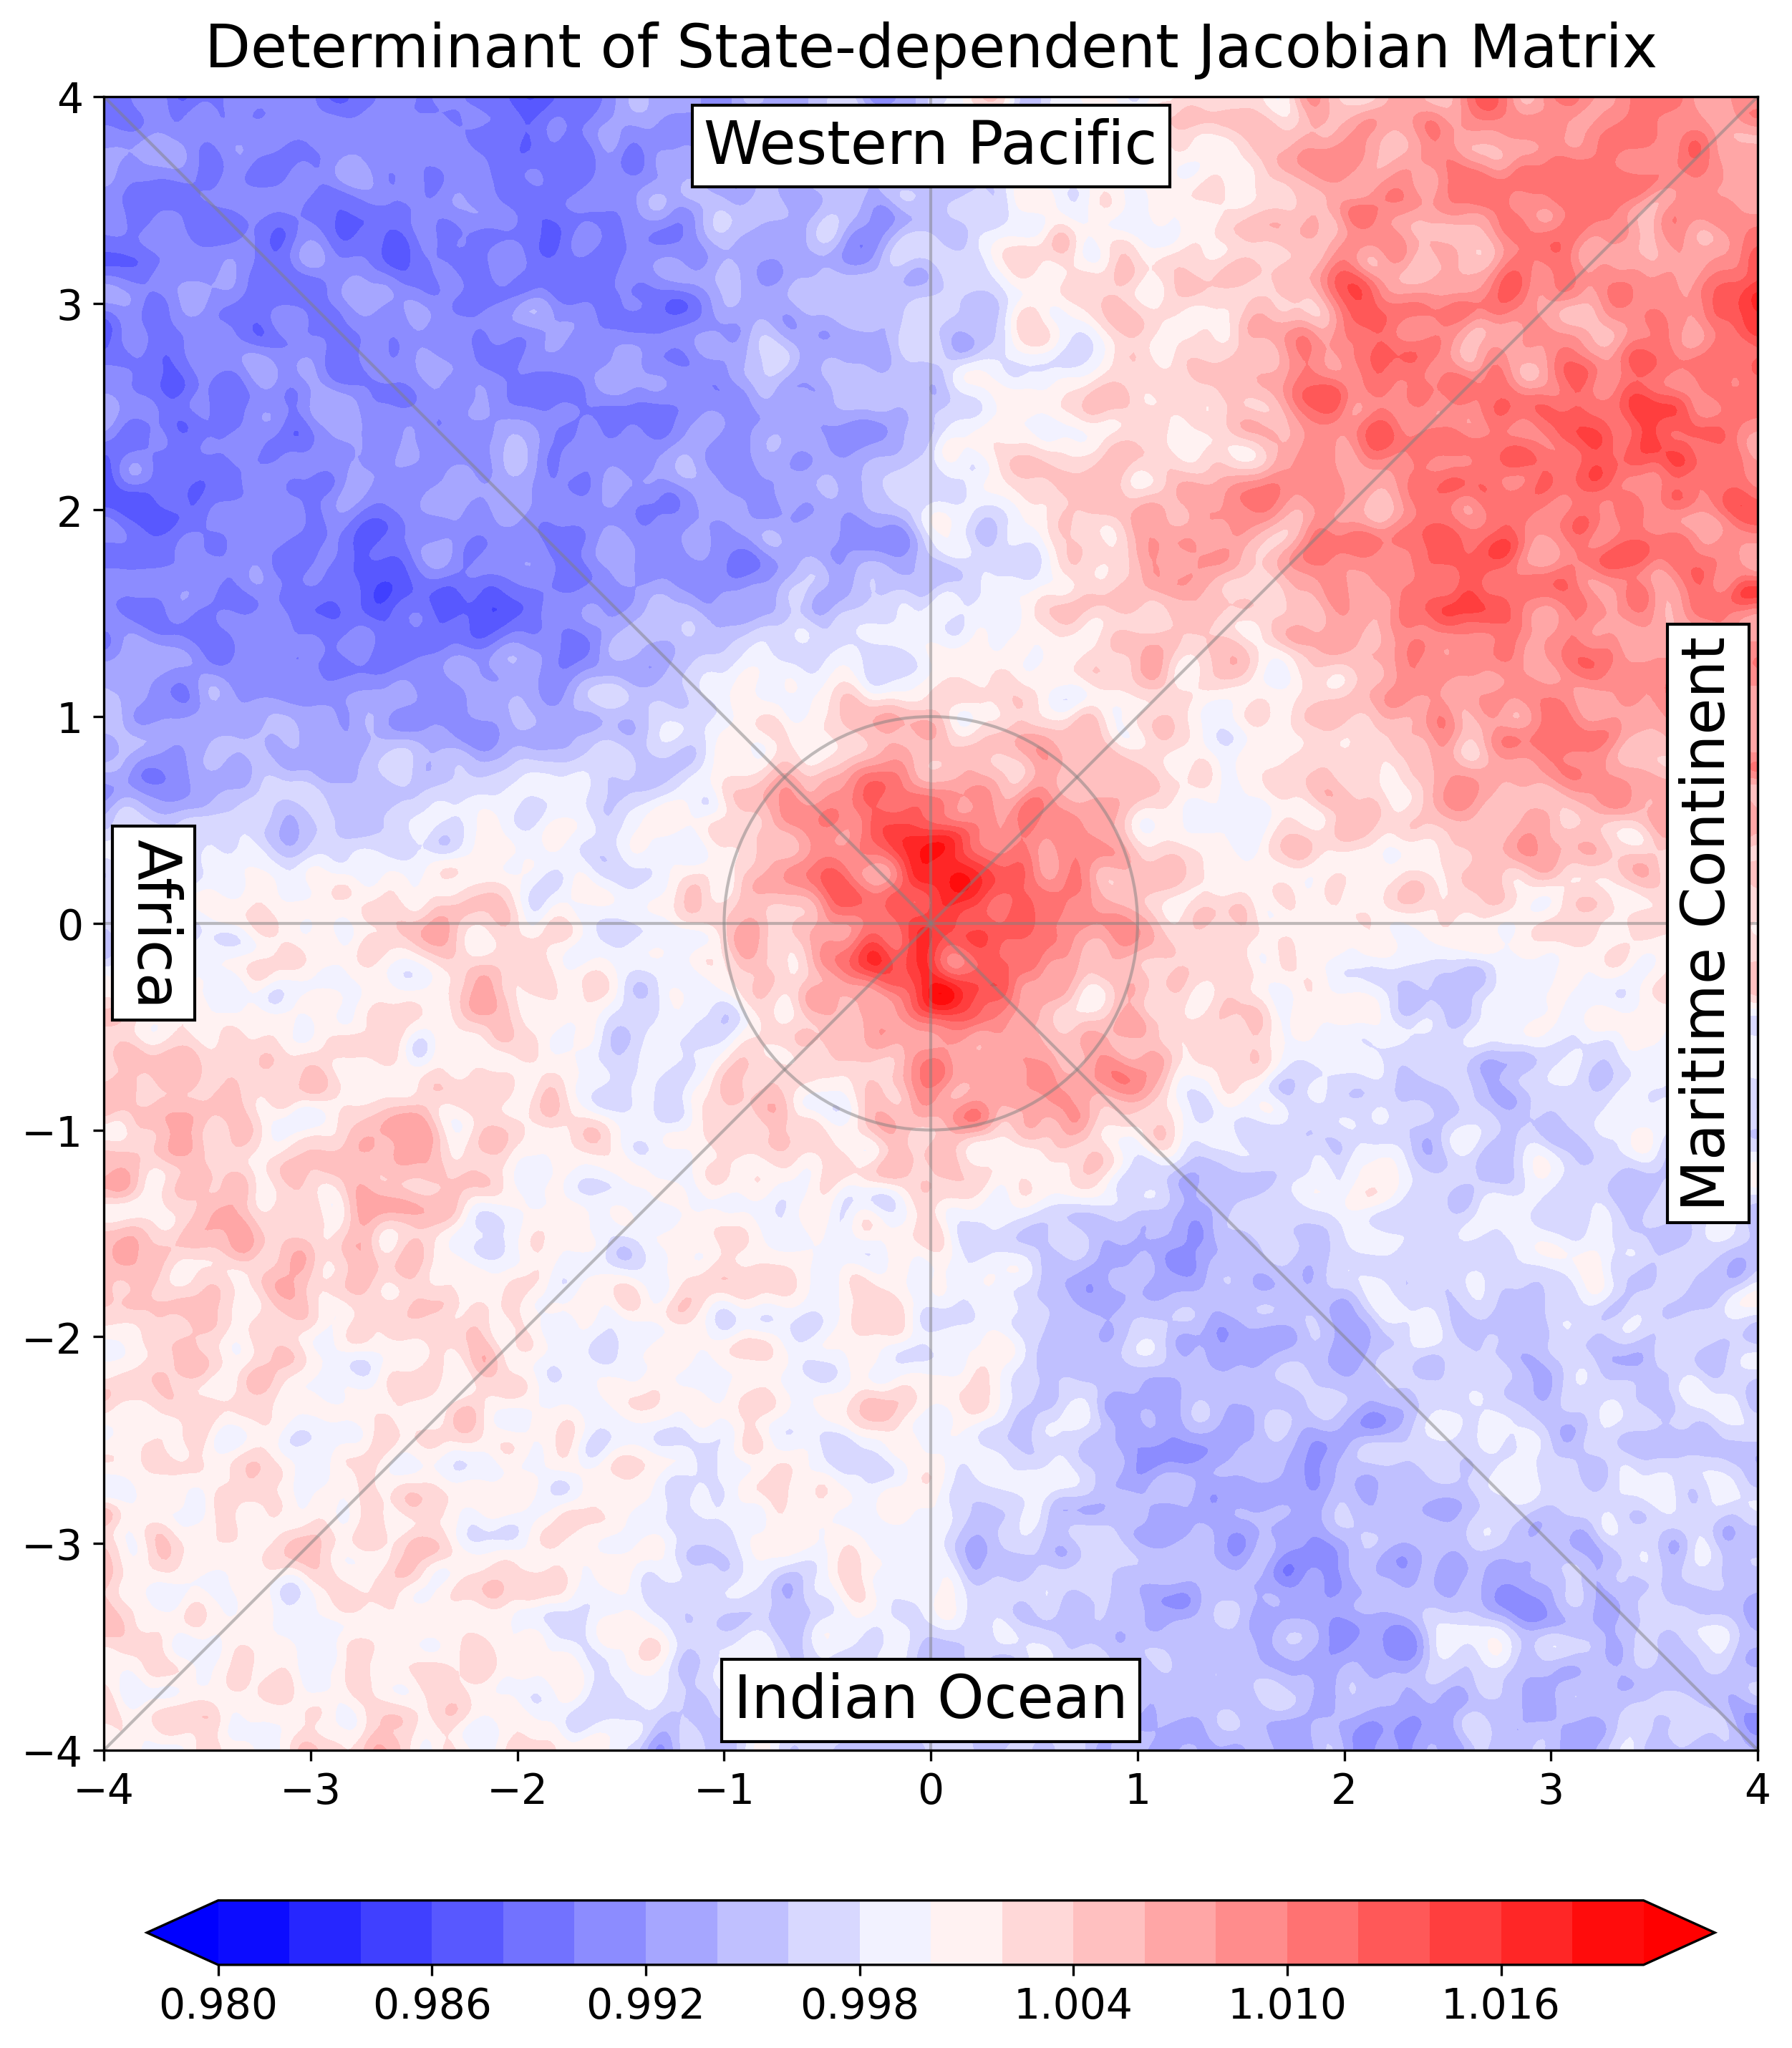

In [7]:
det_list_smoothed = gaussian_filter(det, 3) # smoothing the determinant for better visualization
fig = plt.figure(figsize = (10, 10), dpi = 300)
ax  = plt.axes()
ax.set_aspect("equal")
axc = plt.contourf(X, Y, np.abs(det_list_smoothed), cmap = "bwr", levels = np.arange(0.98, 1.02+1e-9, 0.002), extend = "both")
plot_phase(ax)

ax.tick_params(axis = "both", labelsize = 14)
plt.xlim([-4, 4]); plt.ylim([-4, 4])
plt.title("Determinant of State-dependent Jacobian Matrix", fontsize = 20, pad = 10)

plt.text(-3.9, 0, "Africa", fontsize = 20, ha = "left", va = "center", rotation = 270, bbox = dict(facecolor="white", edgecolor="black"))
plt.text(0, -3.9, "Indian Ocean", fontsize = 20, ha = "center", va = "bottom", rotation = 0, bbox = dict(facecolor="white", edgecolor="black"))
plt.text(3.9, 0, "Maritime Continent", fontsize = 20, ha = "right", va = "center", rotation = 90, bbox = dict(facecolor="white", edgecolor="black"))
plt.text(0, 3.9, "Western Pacific", fontsize = 20, ha = "center", va = "top", rotation = 0, bbox = dict(facecolor="white", edgecolor="black"))

cbox = fig.add_axes([ax.get_position().x0 + 0.02, ax.get_position().y0 - 0.1, ax.get_position().x1 - ax.get_position().x0 - 0.04, 0.03])
cbar = plt.colorbar(axc, cax = cbox, orientation = "horizontal")
cbox.tick_params(axis = "x", labelsize = 14)

## References

Joseph Liouville. Note sur la théorie de la variation des constantes arbitraires. Journal de mathématiques pures et appliquées, 3:342–349, 1838.